# Introduction

量子フーリエ変換および量子位相推定は、量子機械学習において広く使用されている量子行列反転を含む、多くの量子アルゴリズムの基礎を提供する。したがって、より複雑なアルゴリズムに移る前に、これらの構成要素について十分に理解しておくことは価値があります。 

アルゴリズムの入力と出力は、古典的な情報を持たない量子状態です。


In [1]:
!pip install qiskit==0.8.0
!pip install qiskit-aqua==0.4.0

import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
π = np.pi

# Quantum Fourier Transform

離散フーリエ変換はベクトル$\vec{x}=\begin{bmatrix}x_0\\ \vdots\\ x_{N-1}\end{bmatrix}$ を $\vec{y}=\begin{bmatrix}y_0\\ \vdots\\ y_{N-1}\end{bmatrix}$に写像します。
$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{ \boldsymbol{2\pi i} \frac{jk}{N}}$.

量子フーリエ変換は振幅エンコードされた量子状態$|x\rangle=\sum_{i=0}^{N-1} x_i |i \rangle$ を、量子状態 $|y\rangle=\sum_{k=0}^{N-1} y_k |k \rangle$

$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{\boldsymbol{2\pi i} \frac{jk}{N}}$に写像します。

変換された状態もまた基底の重ね合わせにあるので、本質的には振幅だけが変換されます。

$N=2^n$のとき$| x \rangle = | x_1...x_n \rangle$になり、$x_1$が最も重要なビットになります。
$y$は$j = 0.j_1...j_n = \sum_{k=1}^n j_k/2^k$のような二進数で表されます。 例えば、$0.8125_d = 0.1101_b = \sum_{k=1}^4 j_k/2^k = 1/2 + 1/4 + 0/8 + 1/16$, $d$が十進数、$b$が二進数

ユニタリ変換$U$は
\begin{aligned}
U |x \rangle = U |x_1 x_2 \cdots x_n \rangle& = \frac{1}{\sqrt{N}} \sum_{k=0}^{2^n-1} e^{\boldsymbol{2\pi i} xk / 2^n} |k \rangle \\
& = \frac{1}{\sqrt{N}} \sum_{k_1=0}^{1}\ldots\sum_{k_n=0}^{1} e^{\boldsymbol{2\pi i} x\left(\sum_{l=1}^n k_l2^{-l}\right) } \vert k_1 ... k_n \rangle \\
& = \frac{1}{\sqrt{N}} \sum_{k_1=0}^{1}\ldots\sum_{k_n=0}^{1} \bigotimes_{l=1}^n e^{\boldsymbol{2\pi i} x k_l2^{-l}} | k_1 ... k_n \rangle \\
& = \frac{1}{\sqrt{N}} \bigotimes_{l=1}^n \sum_{k_l=0}^{1}  e^{\boldsymbol{2\pi i} x k_l2^{-l}} | k_1 ... k_n \rangle \\
& = \frac{1}{\sqrt{N}} \bigotimes_{l=1}^n  \left(|0\rangle + e^{\boldsymbol{2\pi i} x 2^{-l} } |1\rangle \right) \\
& = \frac{1}{\sqrt{N}} \left(|0\rangle + e^{\boldsymbol{2\pi i} 0.x_n} |1\rangle\right) \otimes...\otimes  \left(\vert0\rangle + e^{\boldsymbol{2\pi i} 0.x_1.x_2...x_{n-1}.x_n} |1\rangle\right) 
\end{aligned}

となります（本と表記が違うけどやってることは同じ）

3qubitだと以下のように表されます。

In [0]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(1, 'c')
qft = QuantumCircuit(q, c)
qft.h(q[0])
qft.cu1(π/2, q[1], q[0])
qft.h(q[1])
qft.cu1(π/4, q[2], q[0])
qft.cu1(π/2, q[2], q[1])
qft.h(q[2]);

回路図を描画すると

/usr/local/lib/python3.6/dist-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)


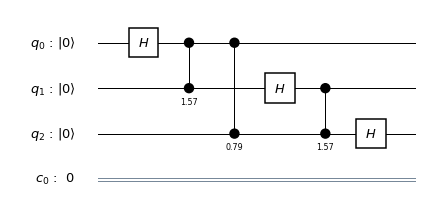

In [3]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(qft)

The conditional rotations dominate the complexity, which scales as $O(N^2)$.

# Quantum phase estimation

ユニタリ行列（演算子）$U$と固有ベクトル$|\psi\rangle$ of $U$から、$U|\psi \rangle =e^{2 i \pi \theta}|\psi \rangle$の$\theta$を推定する。 

$U$ はユニタリ行列なので、絶対値1をもつ。 $\theta$は$[0,1]$で、$|\psi\rangle$に対応した、$U$の位相と呼ばれる。

固有ベクトル$|\psi\rangle$は量子レジスタに格納される。加えて、$n$ qubits がアンシラの量子レジスタに格納される。
手順の最後に、この補助レジスタには、$ \theta $に関連付けられた近似値がnビット精度で含まれることになる。


第一に、アダマールゲート$H$の適用を介して補助レジスタに一様な重ね合わせが準備される。  これらのキュビットは、異なる時間ステップでユニタリ演算子の制御として機能します。

Our goal is to create a superposition of $U$ as the unitary is applied for different durations. Since the eigenvalues are always situated on the complex unit circle, these differently evolved components in the superposition help reveal the eigenstructure. Given that the ancilla register we have a superposition of all possible time steps between $0$ and $2^{n-1}$, we will end up with a superposition of all possible evolutions to encode binary representations of the eigenvalues. 

この手順の最後には、
\begin{aligned}
& \frac {1}{2^{\frac {n}{2}}} (|0\rangle+{e^{2 i \pi \theta \cdot 2^{n-1}}}|1\rangle ) \otimes \cdots (|0\rangle+{e^{2 i \pi \theta \cdot 2^{1}}}|1\rangle ) \otimes (|0\rangle+{e^{2i \pi \theta \cdot 2^{0}}}|1\rangle ) = \\
&\frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{2 i \pi \theta k}|k\rangle
\end{aligned}
となります。

最後のステップとして、補助qubitsに逆フーリエ変換を適用します。
測定すると、補助レジスタに位相が得られます。

\begin{align}
\frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{2i \pi \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} | \tilde{\theta} \rangle \otimes | \psi \rangle
\end{align}

$\tilde{\theta}$は$\theta$の n-bits 推定値です。

![Quantum phase estimation](figures/qpe.svg)

例題として、ユニタリ行列
$\begin{bmatrix}e^{0} & 0 \\0 & e^{i \pi}\end{bmatrix}=\begin{bmatrix}1 & 0 \\0 & -1\end{bmatrix}$の位相を推定してみます。普通に解くと、固有ベクトルは$|0\rangle, |1\rangle$、固有値は$\pm1$で、位相は$\theta_0=0, \theta_1=\frac{1}{2}$です。\\
まず、固有ベクトル$|0\rangle$についてやってみます。

このとき、$C-U^{2^k}$ は$k$が偶数の時controlled-$Z$ ゲートに、$k$が奇数の時単位行列になります。

$|\psi\rangle=|0\rangle$ をメインレジスタに用意し、重ね合わせ状態にします。

In [0]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(2, 'c')

qpe = QuantumCircuit(q, c)
qpe.h(q[0])
qpe.h(q[1]);

次に、コントロールユニタリ変換を実行します。

In [5]:
# Controlled-U0
qpe.cz(q[1], q[2])
# Controlled-U1
# 単位行列なので何もしない

アンシラレジスタに位相を書き込むために量子逆フーリエ変換を適用します

In [6]:
qpe.swap(q[0], q[1])
qpe.h(q[1])
qpe.cu1(-π / 2, q[0], q[1])
qpe.h(q[0])
qpe.swap(q[0], q[1])

最初の2つのレジスタから結果が得られます。

In [7]:
qpe.measure(q[0], c[0])
qpe.measure(q[1], c[1])

回路を描くと

/usr/local/lib/python3.6/dist-packages/qiskit/tools/visualization/_circuit_visualization.py:206: DeprecationWarning: The current behavior for the default output will change in a future release. Instead of trying latex and falling back to mpl on failure it will just use "text" by default
  '"text" by default', DeprecationWarning)


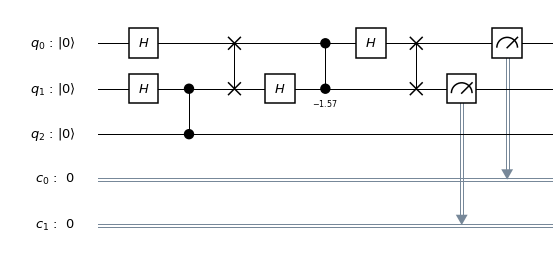

In [8]:
circuit_drawer(qpe)

回路をテストしましょう

In [9]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qpe, backend, shots=1000)
result = job.result()
result.get_counts(qpe)

{'00': 1000}

予想通り、結果は$|2 \cdot \theta_0\rangle=|2\cdot 0\rangle=|00\rangle$

固有ベクトル$|1\rangle$の回路を実行しましょう

In [10]:
qpe = QuantumCircuit(q, c)
qpe.h(q[0])
qpe.h(q[1])
qpe.x(q[2]) # create |1> in the main register

qpe.cz(q[1], q[2])

qpe.swap(q[0], q[1])
qpe.h(q[1])
qpe.cu1(-π / 2, q[0], q[1])
qpe.h(q[0])
qpe.swap(q[0], q[1])

qpe.measure(q[0], c[0])
qpe.measure(q[1], c[1])

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qpe, backend, shots=1000)
result = job.result()
result.get_counts(qpe)

{'10': 1000}

結果は $10 \rightarrow 1\cdot 2^{-1} + 0 \cdot 2^0=\frac{1}{2}=\theta_1$より、$|10\rangle$になるべきです。 実際になっています。

# References
[1] M. Nielsen, I. Chuang. (2000). *Quantum Computation and Quantum Information*. Cambridge University Press. <a id='1'></a>